In [74]:
from bfiw_reg.registrar import BFIWReg
import cv2
import numpy as np
import os
import imageio
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import re

In [75]:
import re

bfi_regex = re.compile(r'B_244-ST_BFI-SE_(\d+).jpg')
bfiw_regex = re.compile(r'B_244-ST_BFIW-SE_(\d+).jpg')

In [76]:
bfi_path = '244_BFIW/BFI'
bfiw_path = '244_BFIW/BFIW'

bfi = {bfi_regex.match(f).group(1).zfill(4): imageio.imread_v2(os.path.join(bfi_path, f)) for f in tqdm(os.listdir(bfi_path)) if f.endswith('.jpg')}
bfiw = {bfiw_regex.match(f).group(1).zfill(4): imageio.imread_v2(os.path.join(bfiw_path, f)) for f in tqdm(os.listdir(bfiw_path)) if f.endswith('.jpg')} 

100%|██████████| 2496/2496 [02:55<00:00, 14.20it/s]


In [26]:
(np.median(sample_bfi_gray)/np.median(sample_bfiw_gray))

0.20689655172413793

(-0.5, 3087.5, 2075.5, -0.5)

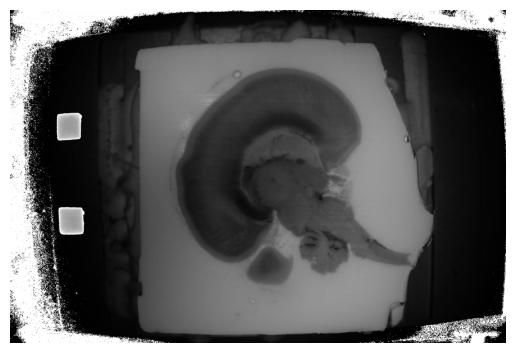

In [29]:
sample_bfi = bfi['1202']
sample_bfiw = bfiw['1202']

sample_bfi_gray = cv2.cvtColor(sample_bfi, cv2.COLOR_RGB2GRAY)
sample_bfiw_gray = cv2.cvtColor(sample_bfiw, cv2.COLOR_RGB2GRAY)

plt.imshow(sample_bfiw_gray - sample_bfi_gray, cmap='gray')
plt.axis('off')


In [9]:
reg = BFIWReg(src_dir='244_BFIW/BFIW', dest_dir='244_BFIW_reg/BFIW',ref_idx='1608', regex= re.compile(r'B_244-ST_BFIW-SE_(\d+).jpg'))

In [10]:
reg.register()

100%|██████████| 2496/2496 [15:26<00:00,  2.69it/s]


Applying Reference Slide Mask to all slides


100%|██████████| 2496/2496 [18:42<00:00,  2.22it/s]


Applying Reference Slide Crop to all slides


100%|██████████| 2496/2496 [00:00<00:00, 175139.82it/s]


Applying Own Slide Block Crop to all slides


100%|██████████| 2496/2496 [00:14<00:00, 177.24it/s]


In [11]:
reg.save_output()

Saving `img` and `msr_img` of all slides


100%|██████████| 2496/2496 [01:22<00:00, 30.43it/s]


In [51]:
retinex_imgs = [slide.img for slide in reg.slides.values()]

In [69]:
ret_imgs = retinex_imgs[::130]

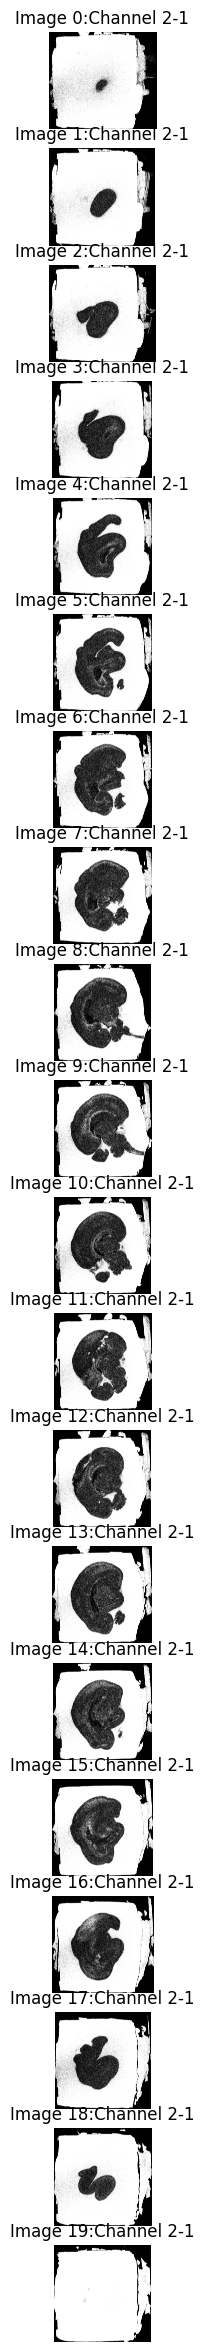

In [72]:
# fig, ax = plt.subplots(len(ret_imgs), 3, figsize=(30, 30))

# for i, img in enumerate(ret_imgs):
#     for j in range(3):
#         img_ = img[:,:,j]
#         ax[i][j].imshow(img_, cmap='gray')
#         ax[i][j].axis('off')
#         ax[i][j].set_title(f'Image {i}:Channel {j}')
# plt.show()
fig, ax = plt.subplots(len(ret_imgs), 1, figsize=(30, 30))
for i, img in enumerate(ret_imgs):
    img__ = np.abs(np.mean(img[:,:,:], axis=2)-img[:,:,1])
    img__[img__>2]=255
    ax[i].imshow(img__, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Image {i}:Channel 2-1')
    # ret_imgs[i] = 255-np.abs(np.mean(img[:,:,1:], axis=2)-img[:,:,0])




In [78]:
# Sort BFI

bfi = dict(sorted(bfi.items(), key=lambda x: x[0]))
bfiw = dict(sorted(bfiw.items(), key=lambda x: x[0]))


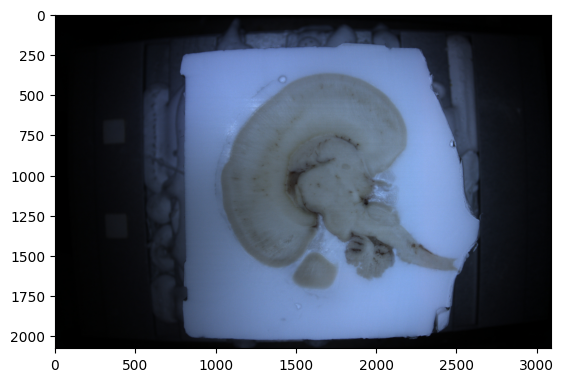

In [80]:
plt.imshow(bfiw['1202'])

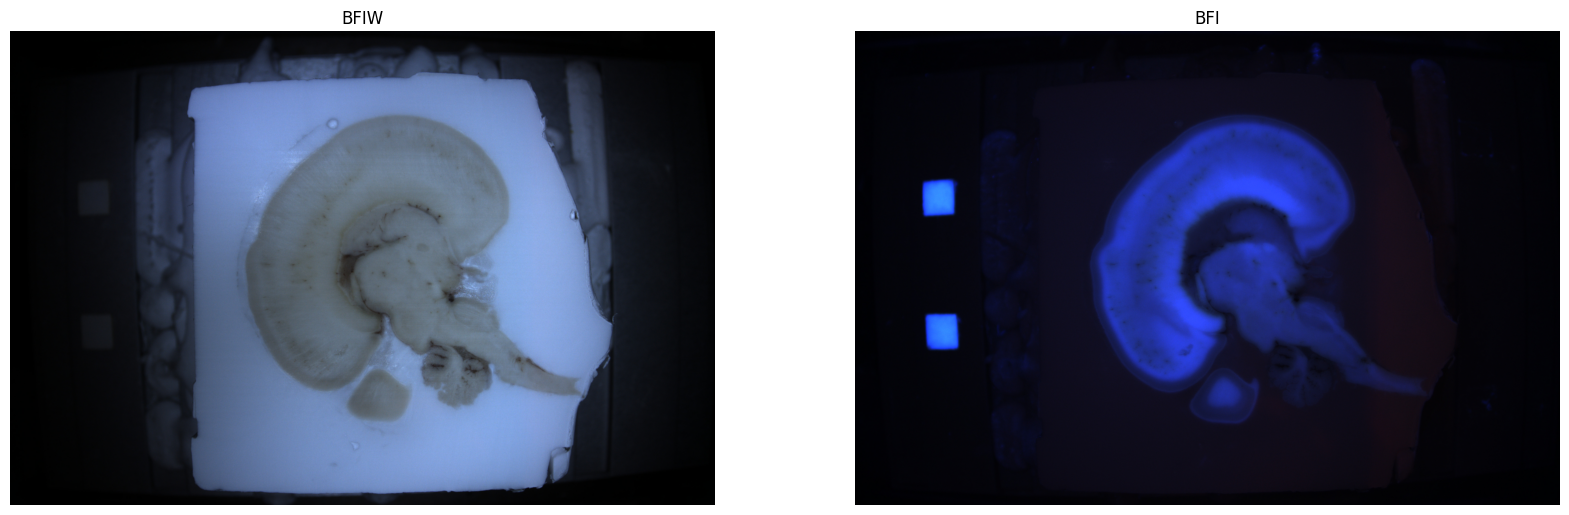

In [81]:
img_bfiw = bfiw['1202']
img_bfi = bfi['1202']

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img_bfiw)
ax[0].axis('off')
ax[0].set_title('BFIW')
ax[1].imshow(img_bfi)
ax[1].axis('off')
ax[1].set_title('BFI')

plt.show()

